Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

# Latent Dirchilet Allocation (LDA) Models (Prepare)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

C:\Users\Samue\Anaconda3\envs\DS-U4-S1-NLP\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [2]:
path = './data/austen-brontë-split'

In [3]:
# 1. Plain python - ''.split command
#  2. Spacy - just the lemmas from the document
#  3. Gensim - simple_preprocess

def tokenize(text):
    "Complete this function"
    
    return [token for token in simple_preprocess(text) if token in STOPWORDS]

In [4]:
import os

def gather_data(path_to_data): 
    data = []
    
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    data.append(tokenize(str(text)))
            
    return data

In [5]:
tokens = gather_data(path)

In [6]:
tokens[0][0:10]

['by', 'and', 'with', 'and', 'seemed', 'to', 'some', 'of', 'the', 'of']

In [7]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

In [8]:
# df['tokens'].head()

## Follow Along

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [9]:
titles = [t[:-4] for t in os.listdir(path) if os.path.isdir(t) == False]

In [10]:
len(titles)

813

In [11]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [12]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

In [13]:
len(tokens)

813

### Author DataFrame


In [14]:
df = pd.DataFrame(index=titles, data={'tokens': tokens})

In [15]:
df.head()

,tokens
Austen_Emma0000,"[by, and, with, and, seemed, to, some, of, the..."
Austen_Emma0001,"[she, were, here, again, what, it, is, that, e..."
Austen_Emma0002,"[all, every, was, every, in, their, not, and, ..."
Austen_Emma0003,"[of, and, of, which, for, the, last, two, or, ..."
Austen_Emma0004,"[some, of, the, had, you, have, of, the, has, ..."


In [16]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [17]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [18]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [19]:
df.head()

,tokens,author,book,section
Austen_Emma0000,"[by, and, with, and, seemed, to, some, of, the...",1,Emma,0
Austen_Emma0001,"[she, were, here, again, what, it, is, that, e...",1,Emma,1
Austen_Emma0002,"[all, every, was, every, in, their, not, and, ...",1,Emma,2
Austen_Emma0003,"[of, and, of, which, for, the, last, two, or, ...",1,Emma,3
Austen_Emma0004,"[some, of, the, had, you, have, of, the, has, ...",1,Emma,4


### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [20]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(str(text))
                yield tokens

In [21]:
streaming_data = doc_stream(path)

In [22]:
# gather_data => returns a list
# doc_stream => returns a generator

In [23]:
streaming_data

<generator object doc_stream at 0x000002AA8439AED0>

In [24]:
# next(streaming_data) # Returns one document at a time from the generator

### Gensim LDA Topic Modeling

In [25]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [26]:
id2word.token2id['girl']

387

In [46]:
id2word[3987]

'england'

In [44]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(2754, 1), (3987, 3), (6602, 1), (6819, 1)]

In [47]:
import sys
sys.getsizeof(id2word)

56

In [55]:
len(id2word.keys())

22096

In [57]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=20, no_above=0.90)

In [58]:
len(id2word.keys())

2881

In [59]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [60]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 4),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [61]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=8
                  )

In [62]:
lda.print_topics()

[(0,
  '0.012*"elinor" + 0.010*"marianne" + 0.007*"sister" + 0.006*"time" + 0.006*"know" + 0.006*"think" + 0.005*"mother" + 0.005*"soon" + 0.005*"miss" + 0.005*"edward"'),
 (1,
  '0.009*"night" + 0.008*"long" + 0.007*"like" + 0.006*"saw" + 0.006*"thought" + 0.006*"heart" + 0.005*"jane" + 0.005*"hand" + 0.005*"life" + 0.005*"sir"'),
 (2,
  '0.012*"little" + 0.011*"bretton" + 0.011*"graham" + 0.009*"dr" + 0.008*"like" + 0.008*"lucy" + 0.007*"know" + 0.007*"think" + 0.007*"papa" + 0.006*"good"'),
 (3,
  '0.026*"madame" + 0.011*"beck" + 0.008*"little" + 0.008*"good" + 0.007*"old" + 0.006*"door" + 0.006*"man" + 0.006*"pere" + 0.006*"thought" + 0.005*"church"'),
 (4,
  '0.009*"hunsden" + 0.009*"like" + 0.008*"know" + 0.006*"man" + 0.006*"st" + 0.006*"good" + 0.006*"john" + 0.006*"yes" + 0.006*"house" + 0.005*"shall"'),
 (5,
  '0.016*"madame" + 0.009*"little" + 0.008*"night" + 0.008*"vous" + 0.007*"like" + 0.007*"beck" + 0.006*"know" + 0.006*"day" + 0.006*"evening" + 0.006*"paulina"'),
 (6,
 

In [63]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [64]:
topics = [' '.join(t[0:5]) for t in words]

In [65]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n")
    print("\n")

------ Topic 0 ------
elinor marianne sister time know


------ Topic 1 ------
night long like saw thought


------ Topic 2 ------
little bretton graham dr like


------ Topic 3 ------
madame beck little good old


------ Topic 4 ------
hunsden like know man st


------ Topic 5 ------
madame little night vous like


------ Topic 6 ------
room adele miss fairfax et


------ Topic 7 ------
elizabeth bennet darcy bingley jane


------ Topic 8 ------
jane sir night love thought


------ Topic 9 ------
emma miss harriet weston thing


------ Topic 10 ------
like little rochester room miss


------ Topic 11 ------
collins lady catherine elizabeth charlotte


------ Topic 12 ------
little monsieur like madame thought


------ Topic 13 ------
rochester sir voice think man


------ Topic 14 ------
mother edward shall mind crimsworth




## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [66]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

C:\Users\Samue\Anaconda3\envs\DS-U4-S1-NLP\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [67]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

C:\Users\Samue\Anaconda3\envs\DS-U4-S1-NLP\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.108735  0.042385       1        1  20.400671
9     -0.093958  0.037637       2        1  17.461811
12     0.046934 -0.021920       3        1  15.201805
10     0.046229 -0.008314       4        1  14.200014
7     -0.154165  0.015951       5        1   8.076287
2      0.027308  0.019701       6        1   7.123754
1      0.118698  0.036896       7        1   5.972430
4      0.000620  0.046295       8        1   5.622165
3      0.055696  0.005397       9        1   1.265498
8      0.044140  0.042661      10        1   1.113500
14    -0.002085  0.053876      11        1   0.873873
11    -0.147549 -0.093405      12        1   0.858032
13     0.035327  0.009963      13        1   0.828175
6      0.041512 -0.158961      14        1   0.722758
5      0.090027 -0.028161      15        1   0.279222, topic_info=     Category         Freq       Term        Total  loglift  logprob
1033  Default   676.000000  elizabeth   676.000000  30.0000  30.0000
135   Default  1740.000000     little  1740.000000  29.0000  29.0000
157   Default  1561.000000       miss  1561.000000  28.0000  28.0000
70    Default   884.000000       emma   884.000000  27.0000  27.0000
2504  Default   396.000000     madame   396.000000  26.0000  26.0000
459   Default   620.000000       lady   620.000000  25.0000  25.0000
125   Default   969.000000       jane   969.000000  24.0000  24.0000
343   Default  1347.000000       like  1347.000000  23.0000  23.0000
729   Default   898.000000       room   898.000000  22.0000  22.0000
385   Default   601.000000        sir   601.000000  21.0000  21.0000
241   Default  1149.000000    thought  1149.000000  20.0000  20.0000
339   Default  1447.000000       know  1447.000000  19.0000  19.0000
357   Default   627.000000      night   627.000000  18.0000  18.0000
2669  Default   652.000000     elinor   652.000000  17.0000  17.0000
240   Default  1323.000000      think  1323.000000  16.0000  16.0000
317   Default  1370.000000       good  1370.000000  15.0000  15.0000
52    Default  1070.000000        day  1070.000000  14.0000  14.0000
1691  Default   379.000000    fairfax   379.000000  13.0000  13.0000
244   Default  1322.000000       time  1322.000000  12.0000  12.0000
2811  Default   362.000000  rochester   362.000000  11.0000  11.0000
2531  Default   433.000000      darcy   433.000000  10.0000  10.0000
2521  Default   347.000000     bennet   347.000000   9.0000   9.0000
382   Default   935.000000      shall   935.000000   8.0000   8.0000
144   Default   913.000000        man   913.000000   7.0000   7.0000
2671  Default   539.000000   marianne   539.000000   6.0000   6.0000
2522  Default   328.000000    bingley   328.000000   5.0000   5.0000
97    Default   833.000000      great   833.000000   4.0000   4.0000
2568  Default   185.000000    collins   185.000000   3.0000   3.0000
287   Default   844.000000       come   844.000000   2.0000   2.0000
133   Default   587.000000       life   587.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
207   Topic15     3.269804       self   216.398666   1.6885  -5.4070
357   Topic15     5.742852      night   627.233398   1.1876  -4.8438
2840  Topic15     1.660015         je    70.501740   2.1321  -6.0849
605   Topic15     1.643920      proof    70.664291   2.1201  -6.0946
73    Topic15     4.160062    evening   492.980316   1.1060  -5.1662
897   Topic15     3.263143     called   305.343719   1.3422  -5.4090
135   Topic15     6.714739     little  1740.427246   0.3233  -4.6874
1245  Topic15     3.292067      words   343.799744   1.2324  -5.4002
26    Topic15     4.136427       came   697.751526   0.7529  -5.1719
343   Topic15     4.992231       like  1347.224243   0.2830  -4.9838
287   Topic15     4.117581       come   844.042786   0.5580  -5.1765
52    Topic15     4.172287        day  1070.002075   0.3340  -5.1633
285

### Overall Model / Documents

In [68]:
lda[corpus[0]]

[(0, 0.2531186), (9, 0.74458253)]

In [69]:
distro = [lda[d] for d in corpus]

In [72]:
distro[0]

[(0, 0.25296932), (9, 0.7447318)]

In [73]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [74]:
len(new_distro)

813

In [75]:
df.head()

,tokens,author,book,section
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo...",1,Emma,0
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p...",1,Emma,1
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be...",1,Emma,2
Austen_Emma0003,"[native, highbury, born, respectable, family, ...",1,Emma,3
Austen_Emma0004,"[mention, handsome, letter, weston, received, ...",1,Emma,4


In [76]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [77]:
df.head()

,elinor marianne sister time know,night long like saw thought,little bretton graham dr like,madame beck little good old,hunsden like know man st,madame little night vous like,room adele miss fairfax et,elizabeth bennet darcy bingley jane,jane sir night love thought,emma miss harriet weston thing,like little rochester room miss,collins lady catherine elizabeth charlotte,little monsieur like madame thought,rochester sir voice think man,mother edward shall mind crimsworth,author
Austen_Emma0000,0.253224,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.744477,0.0,0.0,0.0,0.0,0.000000,Austen
Austen_Emma0001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.997083,0.0,0.0,0.0,0.0,0.000000,Austen
Austen_Emma0002,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.997348,0.0,0.0,0.0,0.0,0.000000,Austen
Austen_Emma0003,0.019467,0.0,0.0,0.0,0.0,0.0,0.0,0.241309,0.0,0.736905,0.0,0.0,0.0,0.0,0.000000,Austen
Austen_Emma0004,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.958086,0.0,0.0,0.0,0.0,0.039615,Austen


In [78]:
df.groupby('author').mean()

,elinor marianne sister time know,night long like saw thought,little bretton graham dr like,madame beck little good old,hunsden like know man st,madame little night vous like,room adele miss fairfax et,elizabeth bennet darcy bingley jane,jane sir night love thought,emma miss harriet weston thing,like little rochester room miss,collins lady catherine elizabeth charlotte,little monsieur like madame thought,rochester sir voice think man,mother edward shall mind crimsworth
author,,,,,,,,,,,,,,,
Austen,0.415786,0.004536,0.003018,0.000250,0.002797,0.000000,0.001236,0.177101,0.000000,0.351221,0.017387,0.017234,0.004543,0.00000,0.002005
CBronte,0.017102,0.110109,0.124003,0.023394,0.110291,0.004523,0.012137,0.001090,0.021861,0.008344,0.259036,0.000325,0.274607,0.01541,0.014436


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [79]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [1]:
# Can take a long time to run.
# coherence_values = compute_coherence_values(dictionary=id2word, 
#                                                         corpus=corpus, 
#                                                         path=path, 
#                                                         start=2, 
#                                                         limit=40, 
#                                                         step=6,
#                                                         passes=40)

In [123]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [124]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.935416,2,0
1,-0.939436,8,0
2,-0.952264,14,0
3,-0.912855,20,0
4,-0.905050,26,0


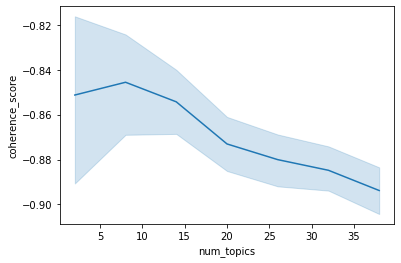

In [125]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [76]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2785
Num Topics = 8  has Coherence Value of 0.3029
Num Topics = 14  has Coherence Value of 0.2887
Num Topics = 20  has Coherence Value of 0.2852
Num Topics = 26  has Coherence Value of 0.2846
Num Topics = 32  has Coherence Value of 0.2914
Num Topics = 38  has Coherence Value of 0.2878


In [89]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.02226036),
 (1, 0.022260414),
 (2, 0.022260347),
 (3, 0.022260347),
 (4, 0.022260392),
 (5, 0.0222604),
 (6, 0.022260347),
 (7, 0.35487327),
 (8, 0.022260398),
 (9, 0.022260517),
 (10, 0.022260416),
 (11, 0.022260422),
 (12, 0.3557417),
 (13, 0.022260347),
 (14, 0.022260347)]

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [78]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [79]:
test = "Ned asked me a question about England today."

In [80]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [81]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [82]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [129]:
people = get_people(doc_stream(path))

In [126]:
doc = nlp(next(doc_stream(path)))

In [128]:
doc.ents[0].lemma_

'yesterday'

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)